# <b> Description </b>
The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

**`D_*`:** Delinquency variables  
**`S_*`:** Spend variables  
**`P_*`:** Payment variables  
**`B_*`:** Balance variables  
**`R_*`:** Risk variables  
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

# <b> Import Libriaries and Read Data </b>

In [ ]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    df = pd.read_parquet(path, columns=usecols)
    return df

In [ ]:
train = read_file(path='train.parquet')
test = read_file(path='test.parquet')
target =pd.read_csv('train_labels.csv')

In [ ]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']

# <b> Overview </b>

In [ ]:
print('The train dataset has {:,d} rows and the test dataset has {:,d} rows. There are {} columns.'.format(train.shape[0], test.shape[0], train.shape[1]))

The train dataset has 5,531,451 rows and the test dataset has 11,363,762 rows. There are 190 columns.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: datetime64[ns](1), float32(93), int16(9), int64(1), int8(86), uint64(1)
memory usage: 2.6 GB


In [ ]:
train.select_dtypes(include=['object']).columns

Index([], dtype='object')

The only object type column other than customer_ID is S_2

In [ ]:
train['S_2']

0          2017-03-09
1          2017-04-07
2          2017-05-28
3          2017-06-13
4          2017-07-16
              ...    
5531446    2017-11-05
5531447    2017-12-23
5531448    2018-01-06
5531449    2018-02-06
5531450    2018-03-14
Name: S_2, Length: 5531451, dtype: object

In [ ]:
#converting to datetype
train.S_2 = pd.to_datetime( train.S_2 )
test.S_2 = pd.to_datetime(test.S_2 )

In [ ]:
#merging train with target and reducing size of customer_ID column
train['customer_ID'] = train['customer_ID'].str[-16:].apply(int, base =16)
target['customer_ID'] = target['customer_ID'].str[-16:].apply(int, base =16)
train = train.merge(target, on ='customer_ID')

In [ ]:
#categorizing features
D_cols = list(train.loc[:,train.columns.str.startswith('D')].columns)
R_cols = list(train.loc[:,train.columns.str.startswith('R')].columns)
S_cols = list(train.loc[:,train.columns.str.startswith('S')].columns)
P_cols = list(train.loc[:,train.columns.str.startswith('P')].columns)
B_cols = list(train.loc[:,train.columns.str.startswith('B')].columns)

In [ ]:
print(f'****There are {len(D_cols)} Delinquency variables')
print(f'****There are {len(R_cols)} Risk variables')
print(f'****There are {len(S_cols)} Spend variables')
print(f'****There are {len(P_cols)} Payment variables')
print(f'****There are {len(B_cols)} Balance variables')

****There are 96 Delinquency variables
****There are 28 Risk variables
****There are 22 Spend variables
****There are 3 Payment variables
****There are 40 Balance variables


# <b>Analysing Null values</b>

In [ ]:
#create a dataframes with percentages of missing values
missing = pd.DataFrame(columns = ['% Missing values'],data = 100*round(train.isnull().sum().sort_values(ascending = False)/len(train),2))
missing_test = pd.DataFrame(columns = ['% Missing values'],data = 100*round(test.isnull().sum().sort_values(ascending = False)/len(test),2)).reset_index().rename(columns={'index': 'variables'})

missing_nz = missing[missing['% Missing values']>0.0].reset_index().rename(columns={'index': 'variables'})
missing_test_nz = missing_test[missing_test['% Missing values']>0.0]


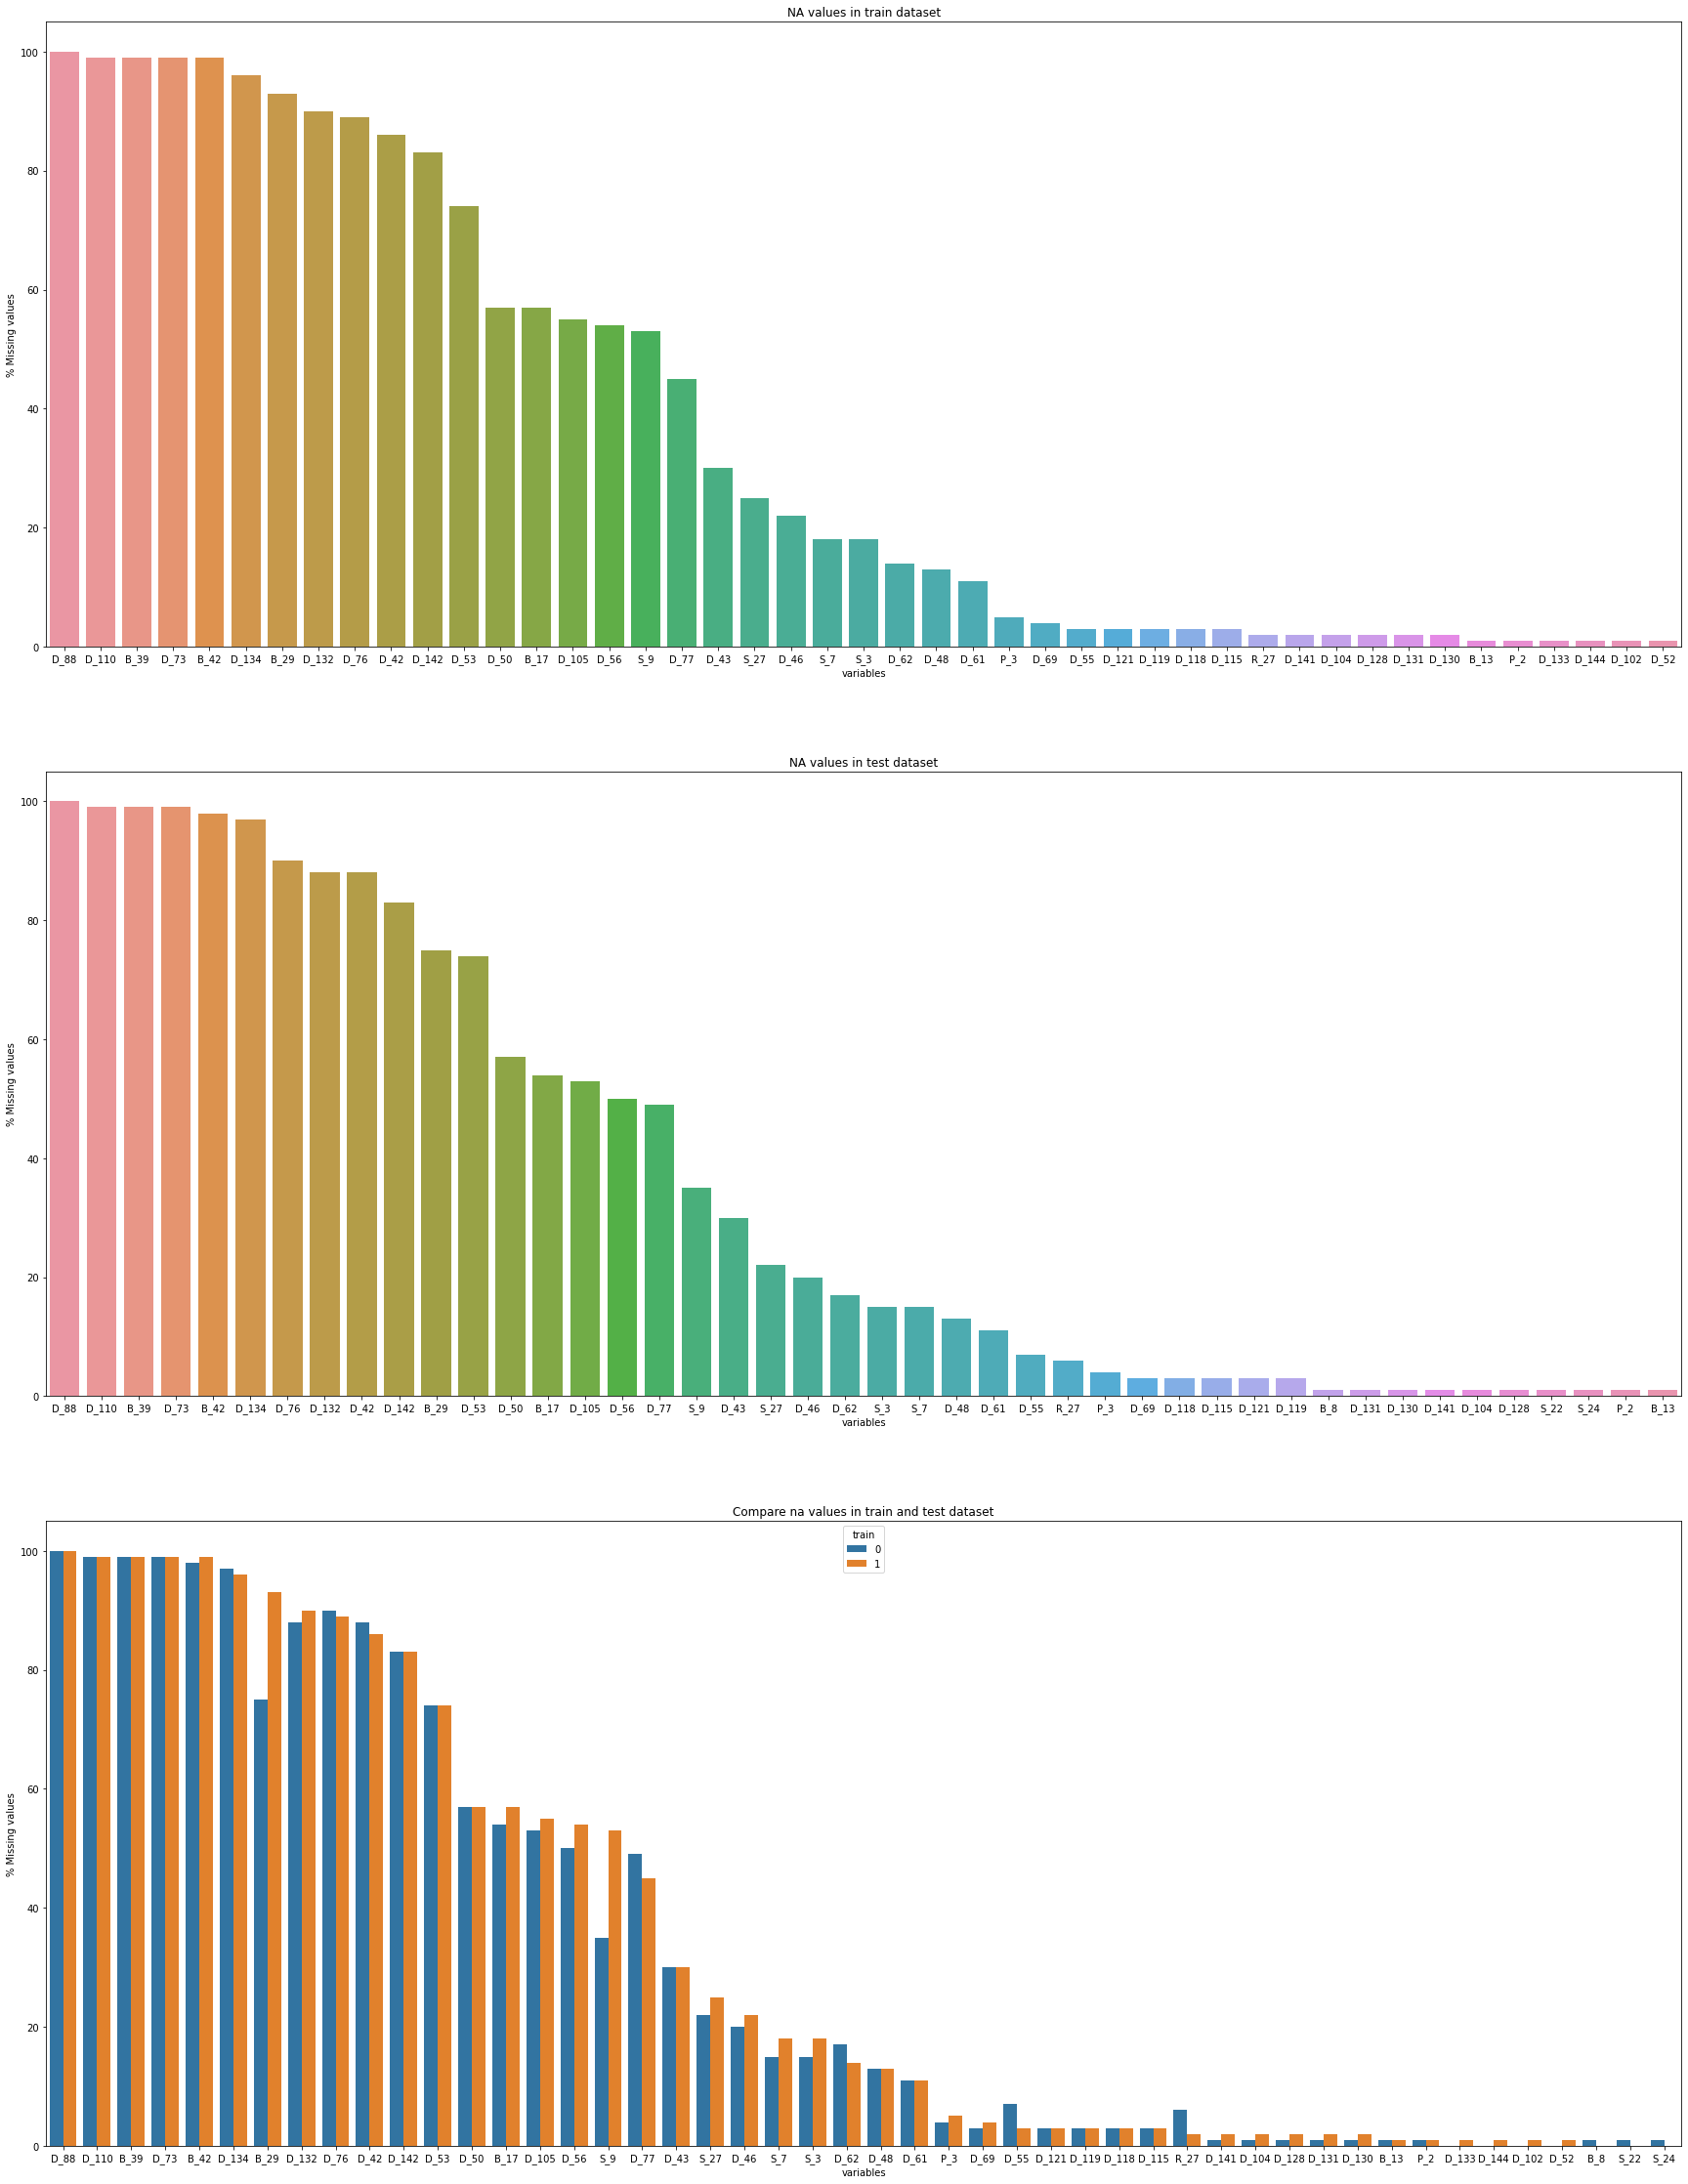

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(30,40))

ax[0].set_title('NA values in train dataset')
sns.barplot(data=missing_nz,x=missing_nz.variables,y=missing_nz['% Missing values'], orient = 'v', ax = ax[0])

ax[1].set_title('NA values in test dataset')
sns.barplot(data=missing_test_nz,x=missing_test_nz.variables,y=missing_test_nz['% Missing values'], orient = 'v', ax = ax[1])

miss_comp= missing_test.loc[missing_nz.index, :]
miss_comp['train'] = 0
missing_nz['train'] = 1
miss_total = missing_nz.append(miss_comp,  ignore_index = True)

ax[2].set_title('Compare na values in train and test dataset')
ax[2] = sns.barplot(data=miss_total,x=miss_total.variables,y=miss_total['% Missing values'], hue='train', orient = 'v')

Insight:   
**There are variables with a high number of missing values (near 100%), these might have to be dropped.**  
**Overall train and test dataset show similar proporions of missing values with two exceptions: B_29 and S_9, in both cases train dataset shows significantly higher numbers of NANs**

In [ ]:
#delete dataframes
del missing, missing_test, missing_nz, missing_test_nz, miss_comp
_ = gc.collect()

# <b>Target variable</b>

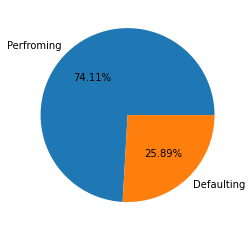

In [ ]:
target_comp=target.target.value_counts(normalize=True)
target_comp.index = ['Perfroming', 'Defaulting']
fig, ax = plt.subplots()
ax.pie(target_comp, autopct='%1.2f%%', labels = target_comp.index)
plt.show()

Insight:  
**The dataset is slightly imbalanced, we might have to use stratisfied kfol or other methods (upsampling etc.)**

# <b>How many statements per customer</b>

In [ ]:
presence = train.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})

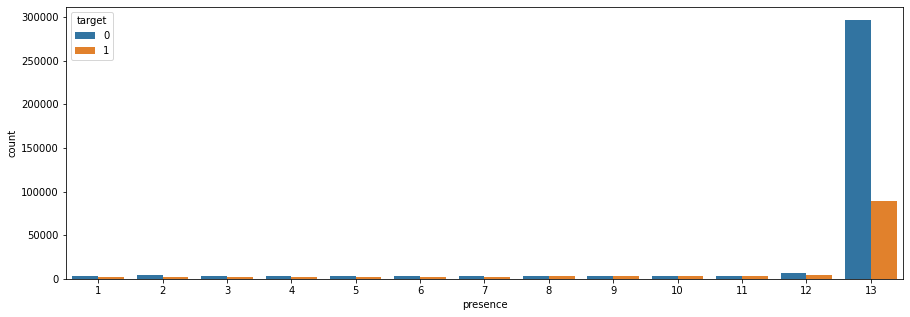

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.countplot(x='presence', data=presence, hue='target', ax=ax)   

plt.show()

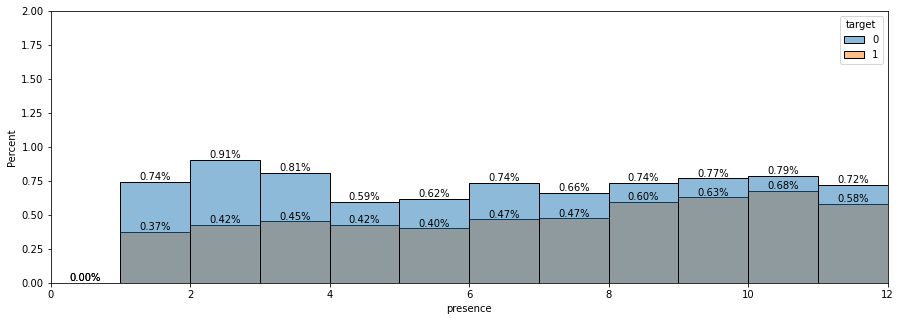

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=presence, hue='target', stat='percent', multiple="layer", bins=np.arange(0,14), ax=ax)

ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_xlim(0,12)
ax.set_ylim(0,2)
plt.show()

Insights  
***-Most customers have 13 statements.  
-Those with less than 13 statements seem to have higher default rates, thus a variable that captues no. of statements could be helpful***

# <b>Correlation with target </b>

In [ ]:
train_agg = train.groupby('customer_ID').tail(1).set_index('customer_ID')

In [ ]:
corr = train_agg.corr()

In [ ]:
corr = corr[['target']].rename(columns = {'target': 'correlation with target'}).sort_values(by = 'correlation with target', ascending = False)

<AxesSubplot:>

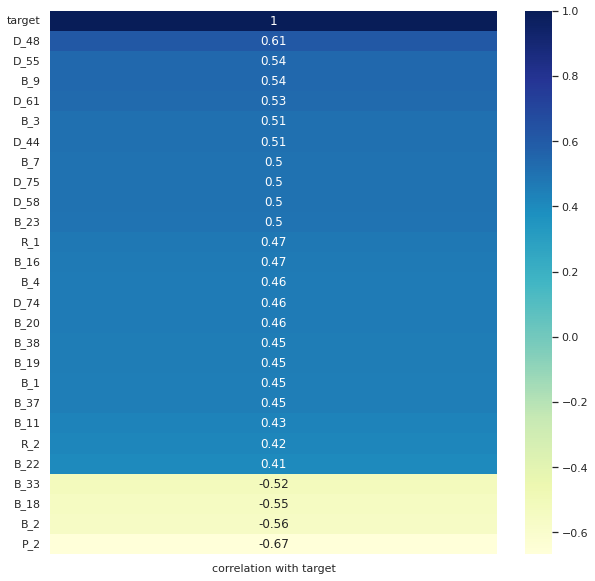

In [ ]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(corr[(corr['correlation with target'] > 0.4) |(corr['correlation with target'] < -0.4) ], xticklabels=corr.columns, annot=True, cmap="YlGnBu")

Displayed are all variables with > |40%| correlation with the target, these might be very important for the model.

# <b>Check distribution of variables </b>

## <b>Delinquency variables</b>

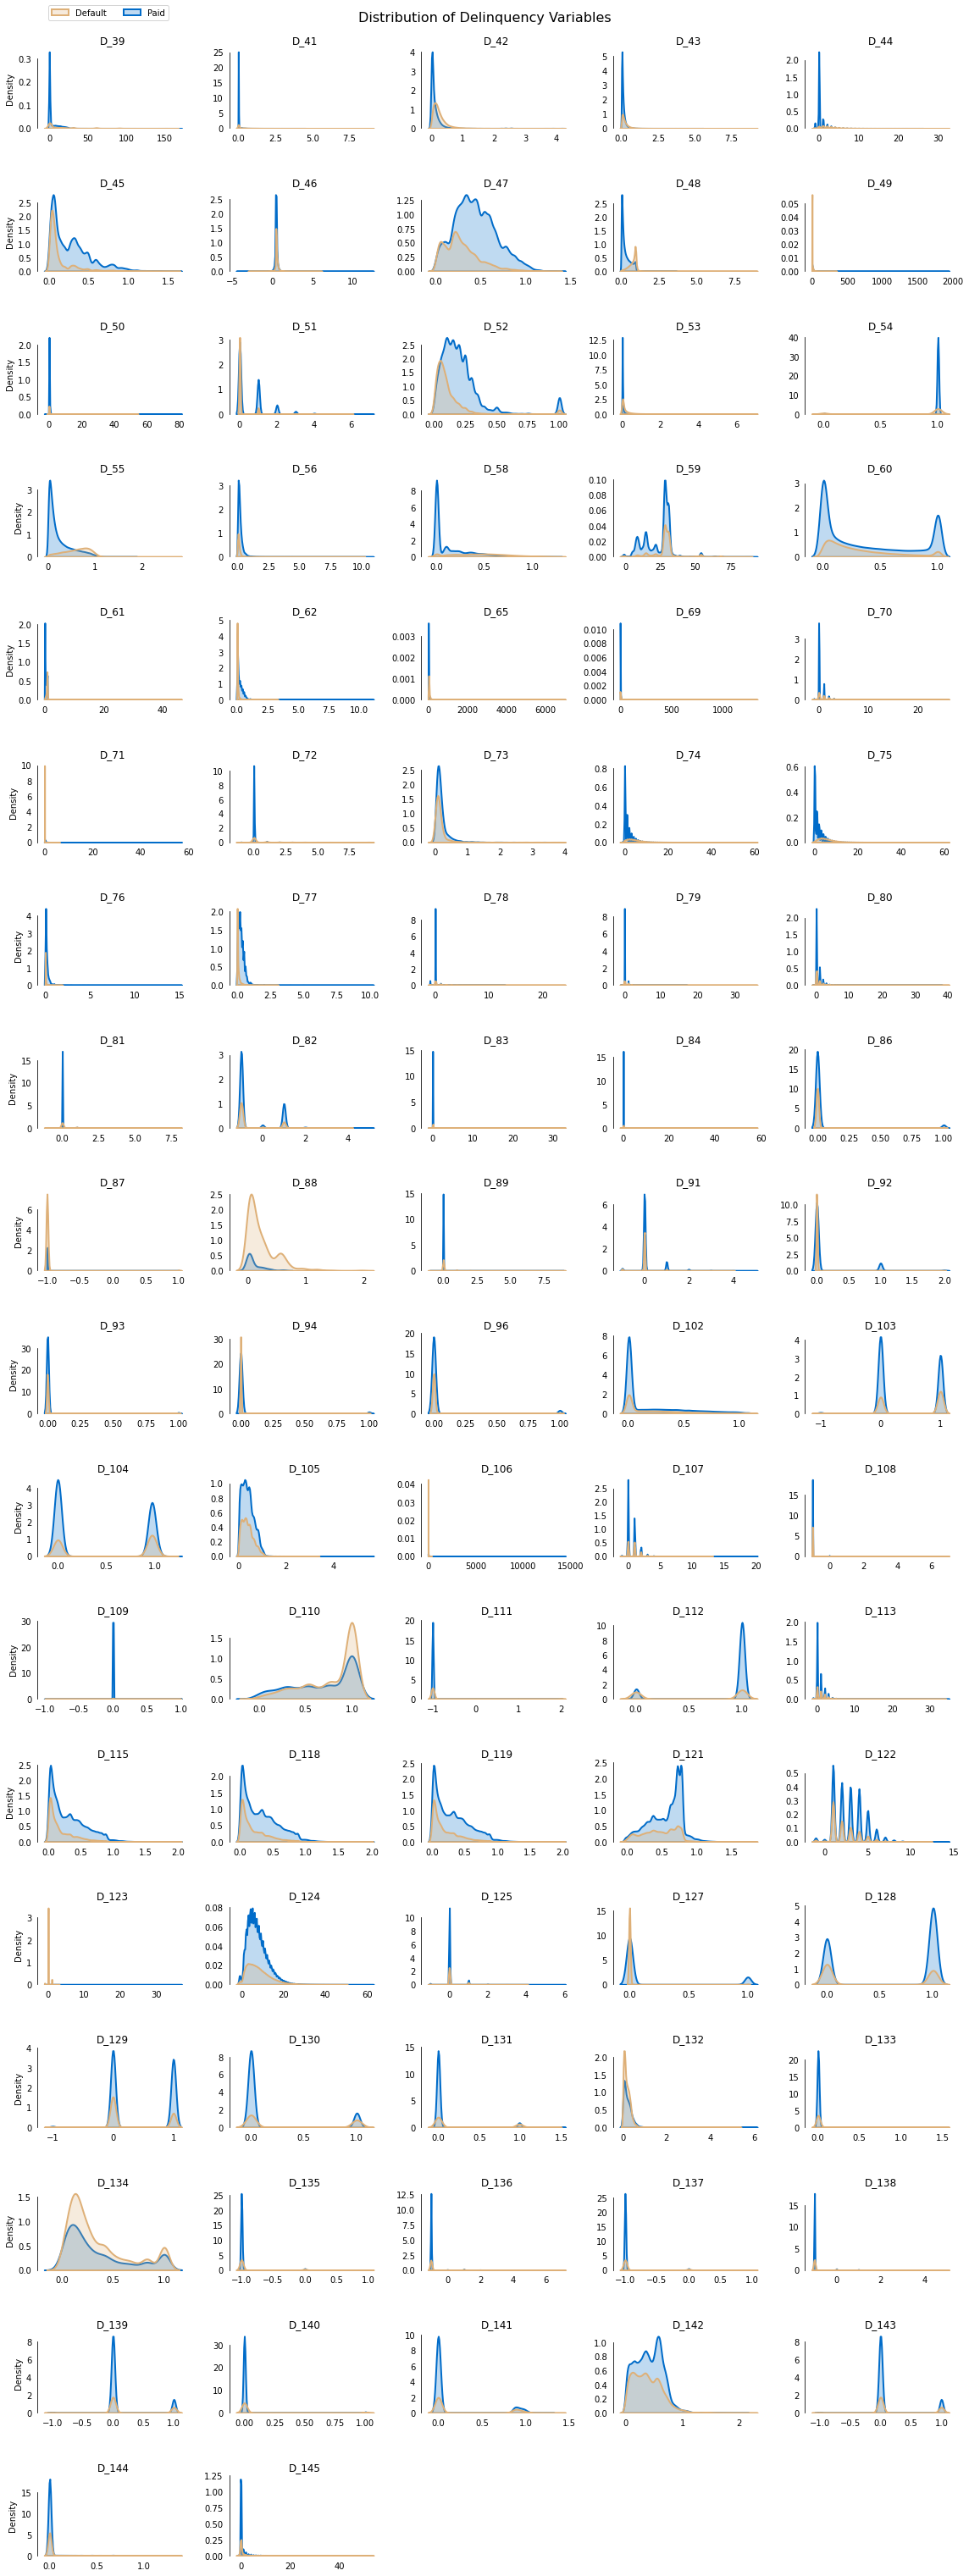

In [ ]:
D_cols_num = [col for col in D_cols if col not in cat_cols]
plot_df=train_agg[D_cols_num+['target']]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

Insight:  
***We have to further distinguish between discrete/ordinal vaiables which could be viewed as categorical in some cases and numeric variables***

# <b>Spend variables</b>

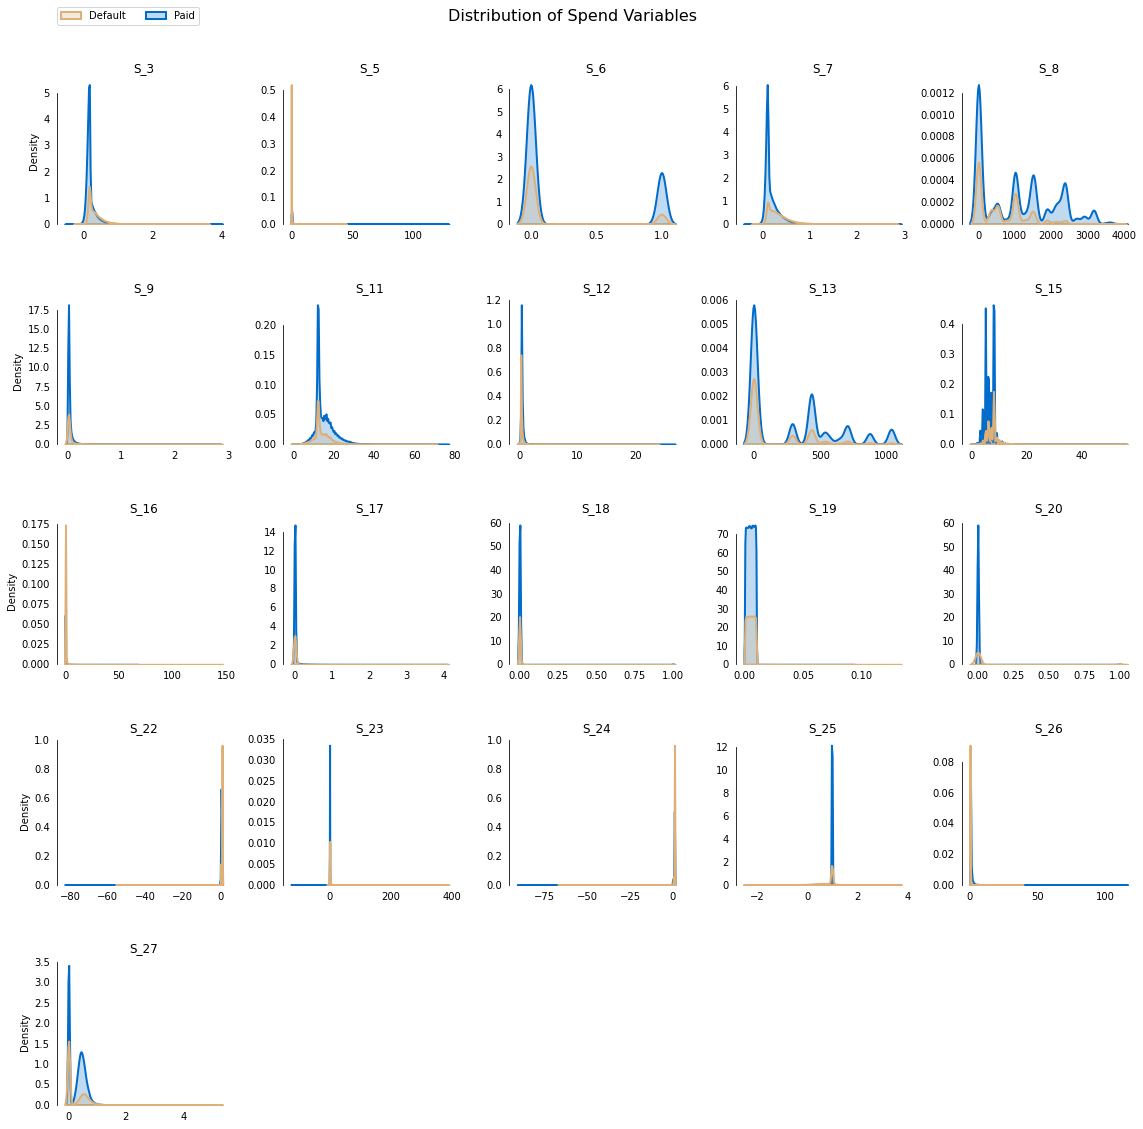

In [ ]:
S_cols_num = [col for col in S_cols if col not in [cat_cols, 'S_2']]
plot_df=train_agg[S_cols_num+['target']]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

# <b>Payment variables</b>

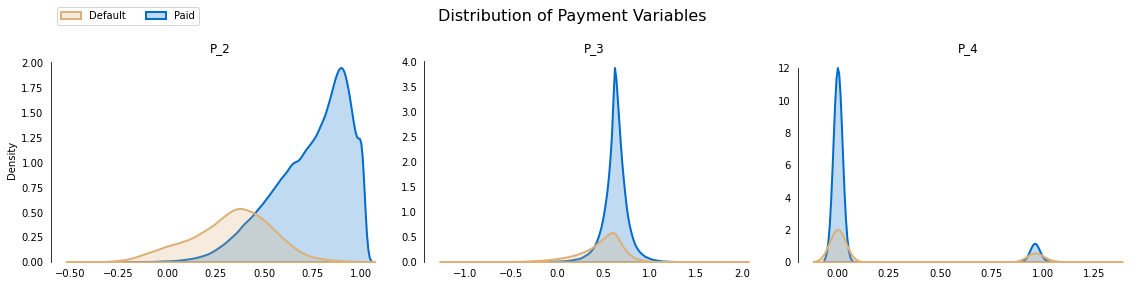

In [ ]:
P_cols_num = [col for col in P_cols if col not in cat_cols]
plot_df=train_agg[P_cols_num+['target']]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribution of Payment Variables',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Density' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

Insight:  
***P_2 shows significantly different behaviour for defaulting customers****

# <b>Balance variables</b>

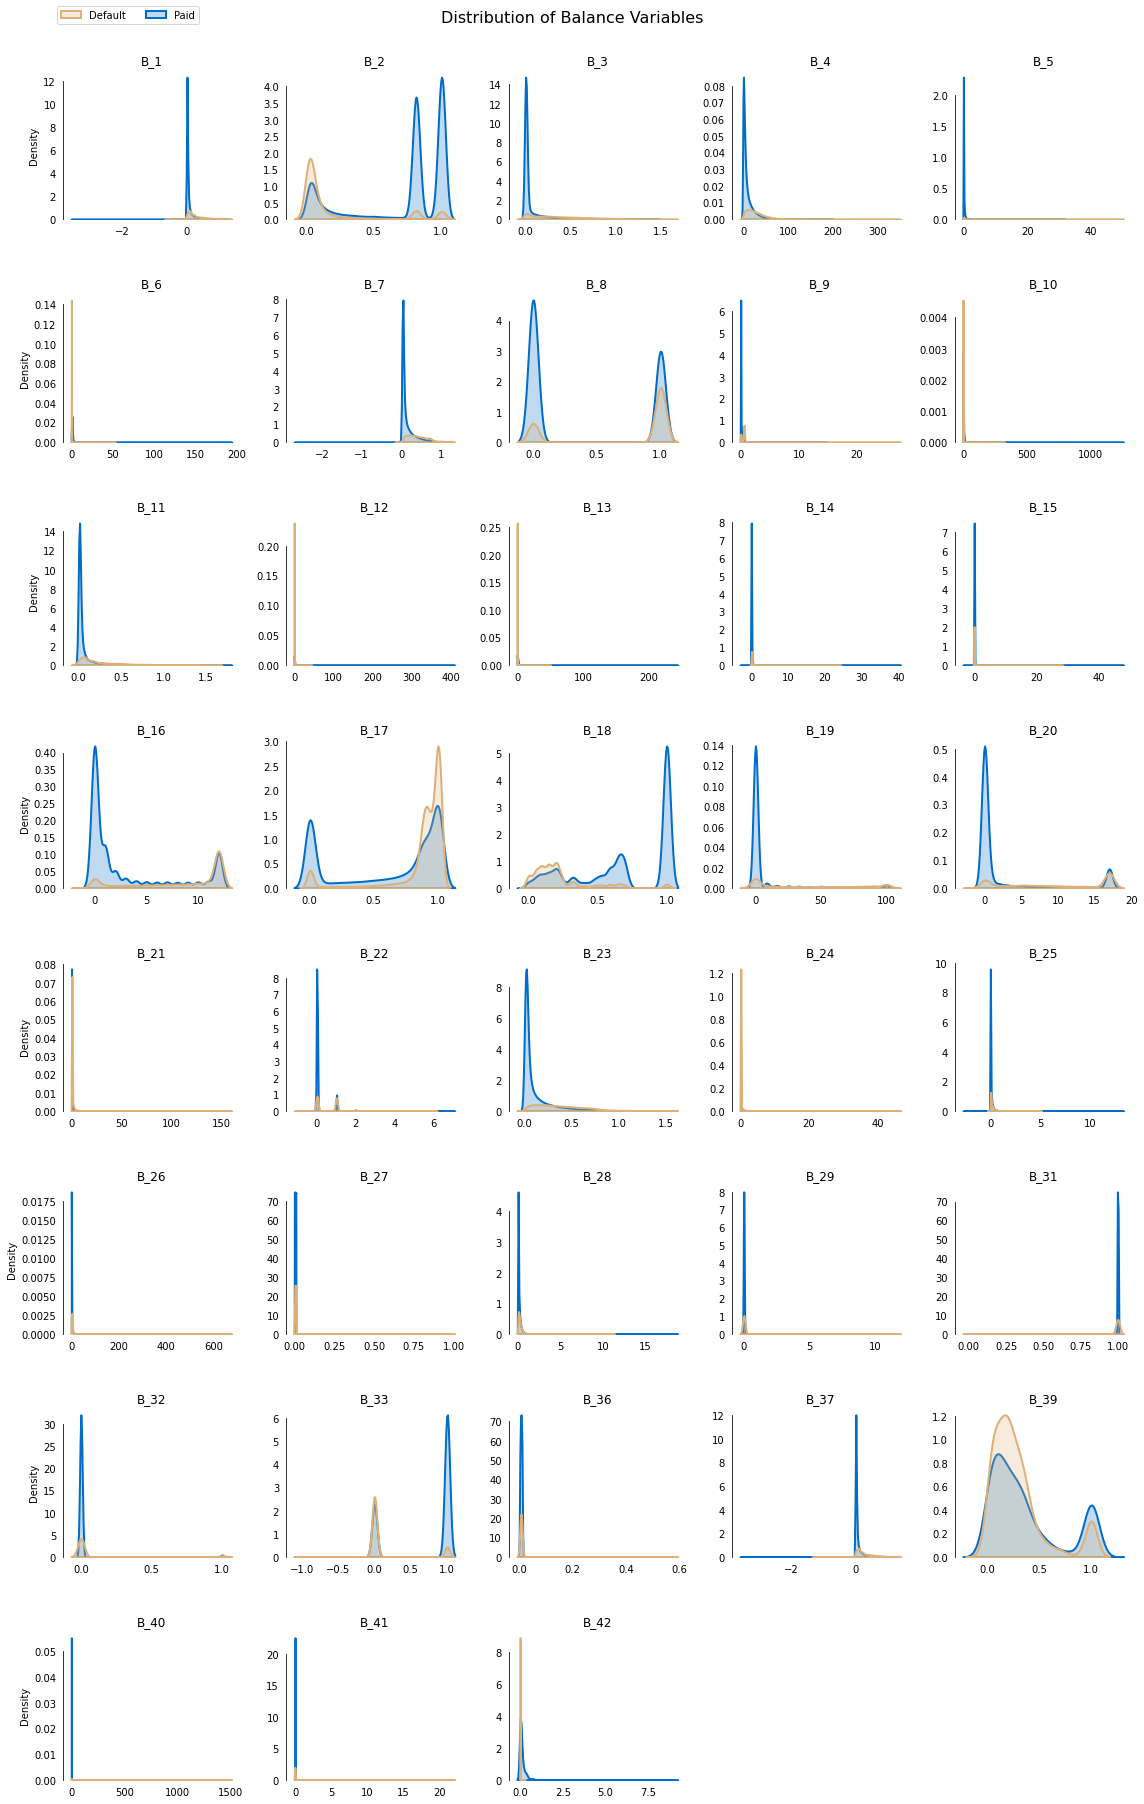

In [ ]:
B_cols_num = [col for col in B_cols if col not in cat_cols]
plot_df=train_agg[B_cols_num+['target']]
fig, ax = plt.subplots(8,5, figsize=(16,32))
fig.suptitle('Distribution of Balance Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

# <b>Risk variables</b>

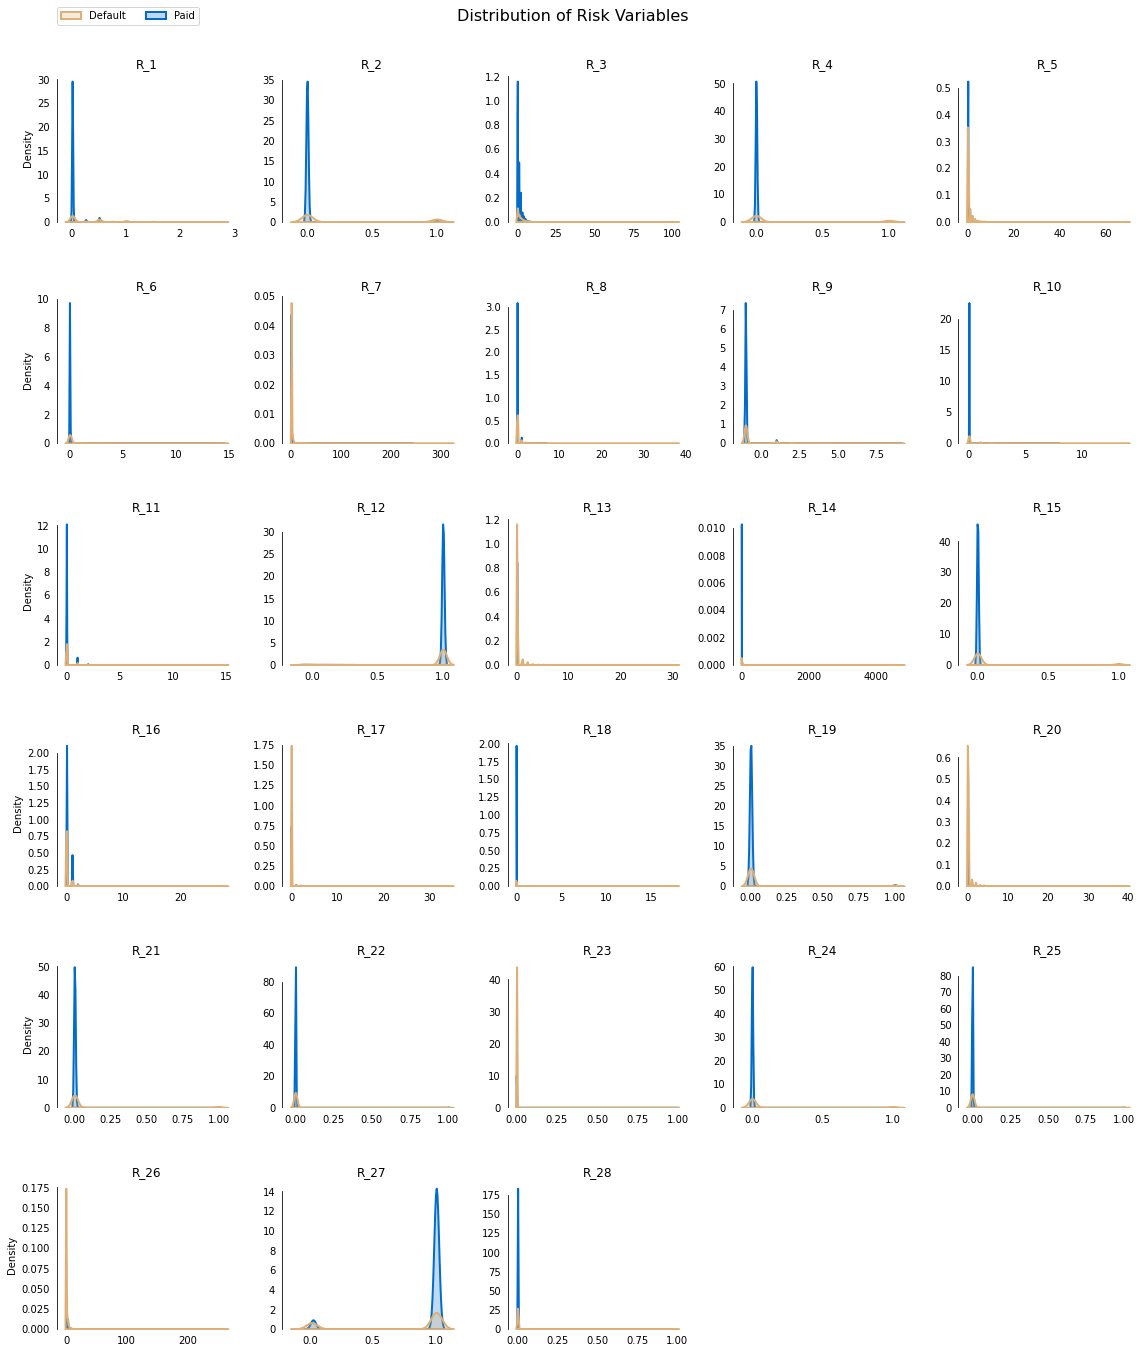

In [ ]:
R_cols_num = [col for col in R_cols if col not in cat_cols]
plot_df=train_agg[R_cols_num+['target']]
fig, ax = plt.subplots(6,5, figsize=(16,24))
fig.suptitle('Distribution of Risk Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

Insight:  
***Almost all variables are multimodal (bimodal) distributed***

# <b> Analyzing categorical features </b>

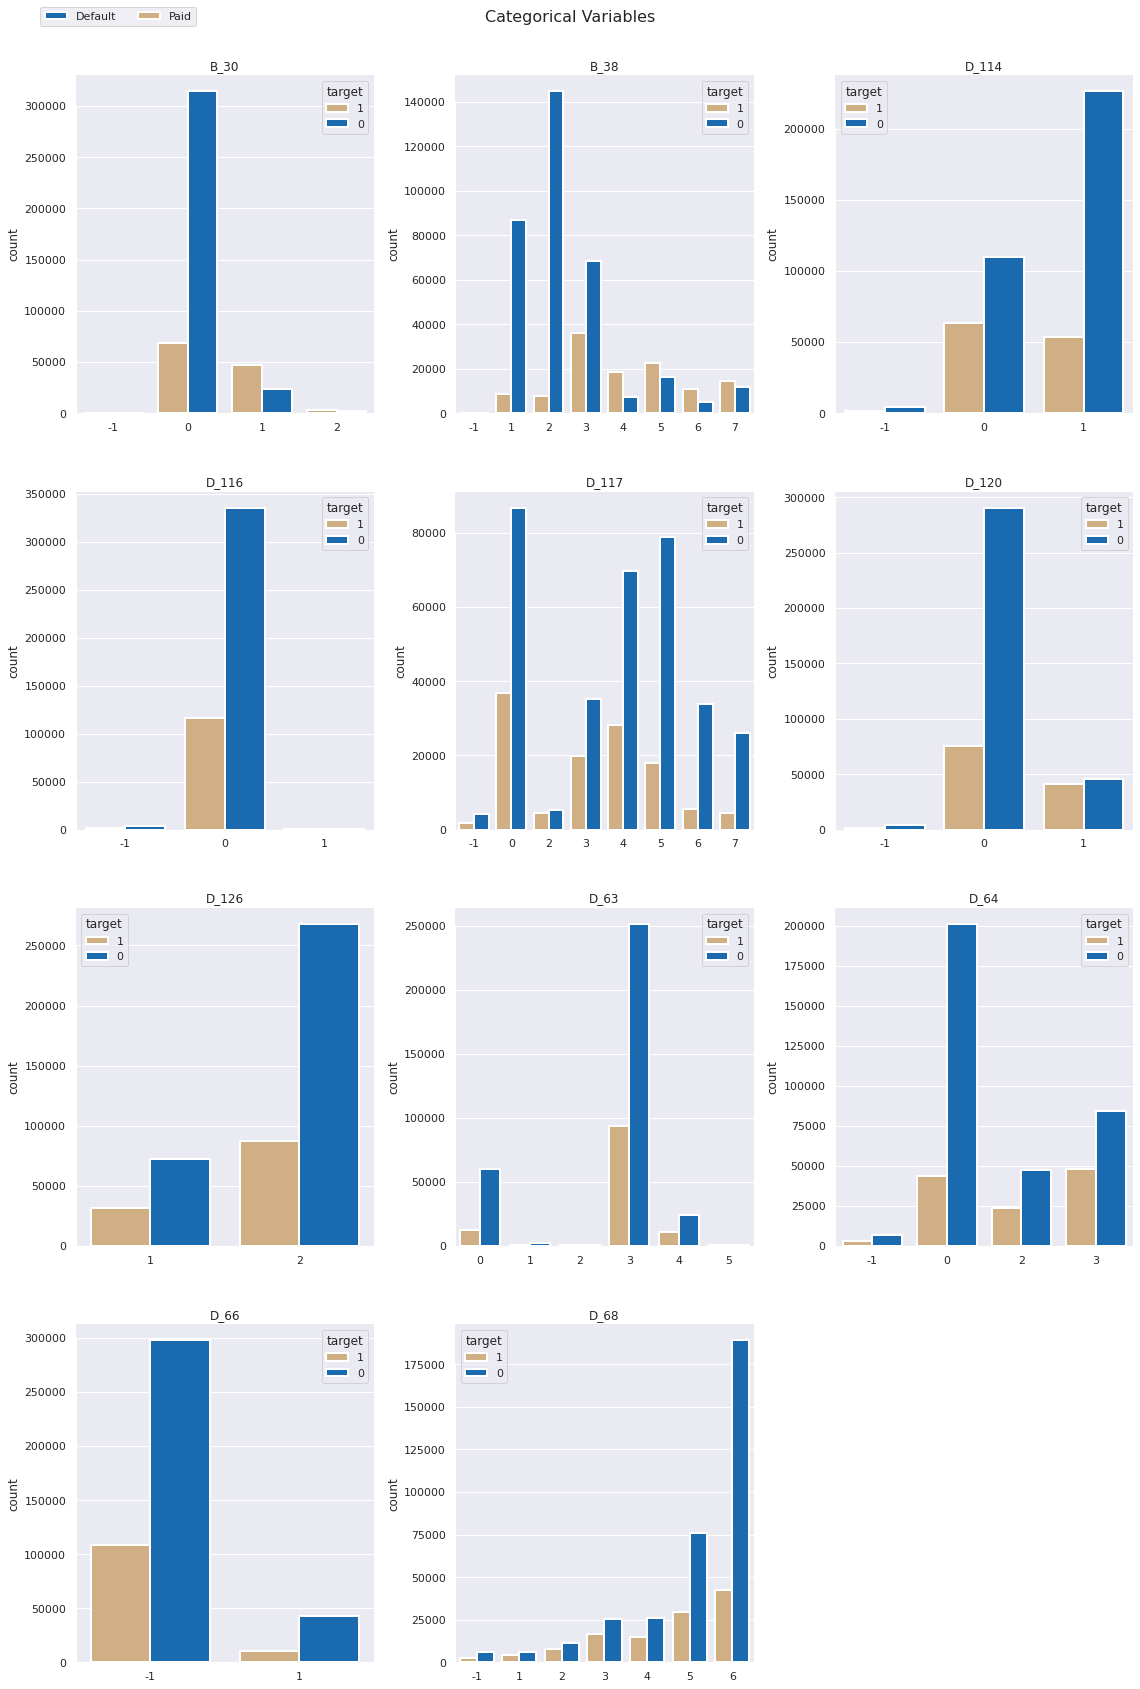

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(16,30))
fig.suptitle('Categorical Variables',fontsize=16)
plot_df=train_agg[cat_cols+['target']]
row = 0
col=[0,1,2]*4
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%3==0):
        row+=1
    sns.countplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], dodge = True, 
                data=plot_df, 
                fill=True, linewidth=2, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='')
    

ax[3,2].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
        

For D_64 value = 3, we see high proportions of default.